## Spectral Normalization with DCGAN

Based in :
 https://arxiv.org/abs/1802.05957

 https://arxiv.org/abs/1511.06434

In [30]:
!pip install pytorch-msssim
!pip install faiss-cpu
!pip install wandb

In [44]:
import torch
import torch.nn.functional as F
from torchvision import models
from pytorch_msssim import ssim  # For SSIM metric
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torchsummary import summary
import torch.optim as optim
import logging

In [32]:
def save_images(epoch):
    os.makedirs('outputs', exist_ok=True)
    fixed_noise = torch.randn(32, 100, device=device)
    fake_images = G(fixed_noise).detach().cpu()
    save_image(fake_images, f'outputs/epoch_{epoch}.png', nrow=8, normalize=True)

In [34]:
# KID (Kernel Inception Distance)
# Based on :  https://medium.com@heyamit10/pytorch-implementation-of-common-gan-metrics-86f993f6e737

def polynomial_mmd(x, y, degree=3, gamma=None, coef0=1):
    x = x.reshape(x.size(0), -1)  # Reshape to 2D
    y = y.reshape(y.size(0), -1)  # Reshape to 2D
    if gamma is None:
        gamma = 1.0 / x.shape[1]
    kernel_xx = (gamma * x.mm(x.t()) + coef0) ** degree
    kernel_yy = (gamma * y.mm(y.t()) + coef0) ** degree
    kernel_xy = (gamma * x.mm(y.t()) + coef0) ** degree
    return kernel_xx.mean() + kernel_yy.mean() - 2 * kernel_xy.mean()



def kernel_inception_distance(real_features, generated_features):
    real_features, generated_features = torch.tensor(real_features), torch.tensor(generated_features)
    return polynomial_mmd(real_features, generated_features)

In [35]:
# number of channels
nc=1

# input noise dimension
nz = 100

# number of generator filters
ngf = 64

#number of discriminator filters
ndf = 64

In [36]:
# Baseline from LAB 5 (INM705 Deep Learning for Image Analysis)

class Generator(nn.Module):
      def __init__(self, nc, ngf, nz):
        super(Generator, self).__init__()
        self.nc = nc
        self.ngf = ngf
        self.nz = nz
        self.model = nn.Sequential(
            nn.Linear(100, 7*7*(self.ngf*4), bias=False),
            nn.BatchNorm1d(7*7*(self.ngf*4)),
            nn.LeakyReLU(0.3),
            nn.Unflatten(self.nc, (self.ngf*4, 7, 7)),
            nn.ConvTranspose2d(self.ngf*4, self.ngf*2, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(self.ngf*2),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(self.ngf*2, self.ngf, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(self.ngf, self.nc, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )

      def forward(self, x):
        return self.model(x)


In [37]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.model = nn.Sequential(
            utils.spectral_norm(nn.Conv2d(self.nc, self.ndf, 5, stride=2, padding=2)),
            nn.LeakyReLU(0.3),
            utils.spectral_norm(nn.Conv2d(self.ndf,self.ndf*2, 5, stride=2, padding=2)),
            nn.LeakyReLU(0.3),
            nn.Flatten(),
            utils.spectral_norm(nn.Linear((self.ndf*2)*7*7, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [38]:
criterion = nn.BCELoss()

n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128

device = 'cuda'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Dataset

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

In [41]:
D = Discriminator(nc,ndf).to(device)
G = Generator(nc,ngf,nz).to(device)

optimizerD = torch.optim.Adam(D.parameters(), lr=5e-4)
optimizerG = torch.optim.Adam(G.parameters(), lr=5e-4)

In [46]:
# Define lists to save scores

# Start a new wandb run to track this script.
run = wandb.init(

          # Set the wandb entity.
          entity="lorrayne-reis-silva-city-university-of-london",
          # Set the wandb project where this run will be logged.
          project="SAGAN-DCGAN_final_run",
          # Track hyperparameters and run metadata.
          config={
              "learning_rate_G": 5e-4,
              "learning_rate_D": 5e-4,
              "architecture": "final-version-SN_DCGAN",
              "dataset": "Fashion-MNIST",
              "epochs": 50,
          },
      )


d_losses = []
g_losses = []
SSIM_SCORES = []
SSIM_SCORES_EPOCHS = []
KID_SCORES = []
KID_SCORES_EPOCHS = []

num_epochs = 50

for epoch in range(num_epochs):

    d_loss_total = 0.0
    g_loss_total = 0.0

    for i, (idx, _) in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with all-real batch
        real_images = idx.to(device)
        real_labels = torch.ones(idx.size(0), 1, device=device)
        fake_labels = torch.zeros(idx.size(0), 1, device=device)

        D.zero_grad()
        output = D(real_images)
        errD_real = criterion(output, real_labels)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        noise = torch.randn(idx.size(0), 100, device=device)
        fake = G(noise)
        output = D(fake.detach())
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D
        optimizerD.step()
        d_loss_total += errD_real.item() + errD_fake.item()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        output = D(fake)
        errG = criterion(output, real_labels)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()
        g_loss_total += errG.item()

        #p = compute_precision_recall(real_images.detach(), fake.detach())
        #print(p)
        run.log({"D_loss": d_loss_total, "G_loss": errG.item()})

        #Compute KID
        kid = kernel_inception_distance(real_images.detach(), fake.detach())
        KID_SCORES.append(kid.item())

        # Compute SSIM
        score = ssim(real_images.detach(), fake.detach())
        SSIM_SCORES.append(score.detach().cpu())



    SSIM_SCORES_EPOCHS.append(np.mean(SSIM_SCORES))
    SSIM_SCORES.clear()

    KID_SCORES_EPOCHS.append(np.mean(KID_SCORES))
    KID_SCORES.clear()

    # Update losses for the epoch
    d_losses.append(d_loss_total / len(dataloader))
    g_losses.append(g_loss_total / len(dataloader))

    # Save model checkpoints
    os.makedirs('./Epochs', exist_ok=True)
    torch.save(G.state_dict(), f'./Epochs/G_epoch_{epoch}.pth')
    torch.save(D.state_dict(), f'./Epochs/D_epoch_{epoch}.pth')

    # Print progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_losses[-1]:.4f}, g_loss: {g_losses[-1]:.4f}')

    #Save images generated in epoch 10,20,50
    if (epoch+1) in [10, 30, 50]:
              save_images(epoch+1)

run.finish

<ipython-input-34-c9143fbaa307>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_features, generated_features = torch.tensor(real_features), torch.tensor(generated_features)


Epoch [1/50], d_loss: 0.7659, g_loss: 1.9614
Epoch [2/50], d_loss: 1.2217, g_loss: 0.9191
Epoch [3/50], d_loss: 1.2398, g_loss: 0.8831
Epoch [4/50], d_loss: 1.1974, g_loss: 0.9071
Epoch [5/50], d_loss: 1.1367, g_loss: 0.9420
Epoch [6/50], d_loss: 1.1420, g_loss: 0.9364
Epoch [7/50], d_loss: 1.1455, g_loss: 0.9351
Epoch [8/50], d_loss: 1.1760, g_loss: 0.8869
Epoch [9/50], d_loss: 1.1913, g_loss: 0.8706
Epoch [10/50], d_loss: 1.2075, g_loss: 0.8571
Epoch [11/50], d_loss: 1.2398, g_loss: 0.8247
Epoch [12/50], d_loss: 1.2548, g_loss: 0.8086
Epoch [13/50], d_loss: 1.2698, g_loss: 0.7952
Epoch [14/50], d_loss: 1.2907, g_loss: 0.7748
Epoch [15/50], d_loss: 1.2993, g_loss: 0.7737
Epoch [16/50], d_loss: 1.3068, g_loss: 0.7968
Epoch [17/50], d_loss: 1.2553, g_loss: 0.8264
Epoch [18/50], d_loss: 1.2911, g_loss: 0.7812
Epoch [19/50], d_loss: 1.3137, g_loss: 0.7540
Epoch [20/50], d_loss: 1.3218, g_loss: 0.7472
Epoch [21/50], d_loss: 1.3186, g_loss: 0.7564
Epoch [22/50], d_loss: 1.3304, g_loss: 0.74

<bound method Run.finish of <wandb.sdk.wandb_run.Run object at 0x79e6a95394d0>>

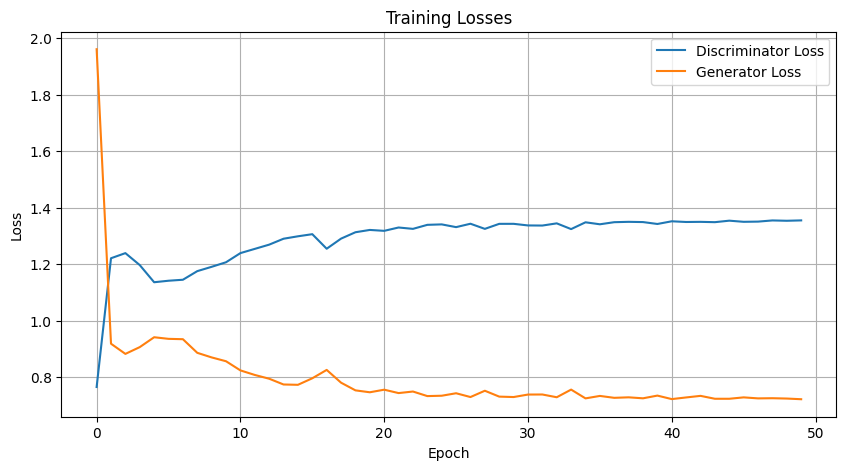

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid()
os.makedirs('./Metrics', exist_ok=True)
plt.savefig('./Metrics/SN_DCGAN_generator_discriminator_losses.png')
plt.show()

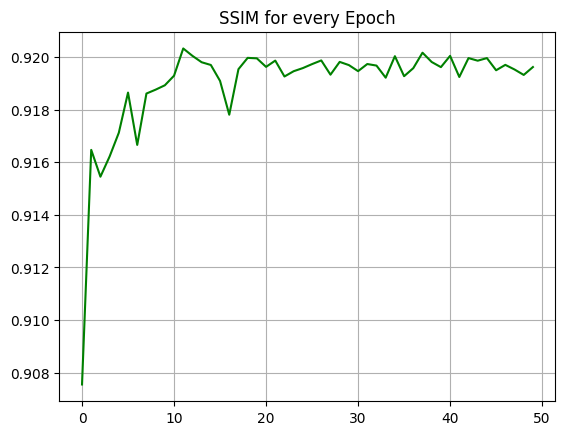

In [48]:
plt.title("SSIM for every Epoch")
plt.plot(SSIM_SCORES_EPOCHS,color="green")
plt.grid()
plt.savefig('./Metrics/SN_DCGAN_SSIM.png')
plt.show()

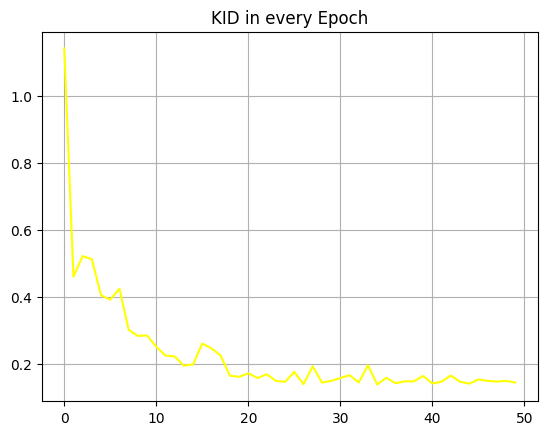

In [49]:
plt.title("KID in every Epoch")
plt.plot(KID_SCORES_EPOCHS,color="yellow")
plt.grid()
plt.savefig('./Metrics/SN_KID_losses.png')
plt.show()